### Prereq: install any necessary libraries you don't already have ↓

In [23]:
#pip install -r requirements.txt

In [24]:
#print out which python is being used
import sys, os
print(sys.executable)

/opt/anaconda3/envs/kdd-env/bin/python


In [25]:
#import libraries
import numpy as np
import pandas as pd
#data processing tools
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
#model training
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
#evaluation
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix,make_scorer, fbeta_score
#visualization
from mlxtend.plotting import plot_decision_regions
from sklearn.tree import plot_tree
from matplotlib import pyplot as plt

# Load data

In [26]:
#load in the data from the dataset

#get name of the zip file
file_path = 'kddcup.data.gz'

#define the column names based on the kddcup.names file
columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", 
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in", 
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations", 
    "num_shells", "num_access_files", "num_outbound_cmds", "is_hot_login", 
    "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate", 
    "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", 
    "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count", 
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", 
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate", 
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"
]

#read the dataset into a pandas dataframe
df = pd.read_csv(file_path, header=None, names=columns, compression='gzip')

#create dictionaries for final evaluation
accuracy_scores = {}
precision_scores = {}
recall_scores = {}

### Basic EDA

In [27]:
df.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


In [28]:
df.tail(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
4898426,0,tcp,http,SF,212,2288,0,0,0,0,...,255,1.0,0.0,0.33,0.05,0.0,0.01,0.0,0.0,normal.
4898427,0,tcp,http,SF,219,236,0,0,0,0,...,255,1.0,0.0,0.25,0.05,0.0,0.01,0.0,0.0,normal.
4898428,0,tcp,http,SF,218,3610,0,0,0,0,...,255,1.0,0.0,0.20,0.05,0.0,0.01,0.0,0.0,normal.
4898429,0,tcp,http,SF,219,1234,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.0,0.01,0.0,0.0,normal.
4898430,0,tcp,http,SF,219,1098,0,0,0,0,...,255,1.0,0.0,0.14,0.05,0.0,0.01,0.0,0.0,normal.


In [29]:
df.sample(10)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
1937155,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,smurf.
2599559,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,smurf.
3426428,0,tcp,http,REJ,0,0,0,0,0,0,...,255,1.00,0.00,0.08,0.21,0.0,0.0,1.0,1.0,normal.
2544147,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,smurf.
2372993,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,smurf.
211999,0,tcp,http,SF,211,331,0,0,0,0,...,255,1.00,0.00,0.07,0.02,0.0,0.0,0.0,0.0,normal.
1405454,0,udp,ntp_u,SF,48,48,0,0,0,0,...,4,0.02,0.01,0.02,0.00,0.0,0.0,0.0,0.0,normal.
2137189,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,smurf.
517374,0,tcp,private,S0,0,0,0,0,0,0,...,17,0.07,0.06,0.00,0.00,1.0,1.0,0.0,0.0,neptune.
465021,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,smurf.


# Data processing

In [30]:
#data processing 1: drop nulls and NaNs
# remove rows with missing values or NaNs
df = df.dropna().reset_index(drop=True)

print(f"Number of rows after dropping missing values: {df.shape[0]} ")

Number of rows after dropping missing values: 4898431 


In [31]:
#data processing 2: data deduplication

#print a sample of the duplicate rows
duplicate_rows = df.duplicated()
print(f"Number of duplicate records: {duplicate_rows.sum()}")

#drop the duplicates
df = df.drop_duplicates().reset_index(drop=True)

#print number of records after removing duplicates
print(f"Number of rows after deduplication: {df.shape[0]}")

#print a small example of some duplicate records
print("Sample of duplicate records:")
df.loc[duplicate_rows].sample(3)

Number of duplicate records: 3823439
Number of rows after deduplication: 1074992
Sample of duplicate records:


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
952144,0,tcp,http,SF,323,278,0,0,0,0,...,250,1.00,0.00,0.06,0.14,0.0,0.0,0.76,0.52,normal.
951080,1,tcp,smtp,SF,1451,327,0,0,0,0,...,176,0.57,0.15,0.03,0.01,0.0,0.0,0.00,0.00,normal.
95568,0,tcp,http,SF,238,397,0,0,0,0,...,255,1.00,0.00,0.02,0.04,0.0,0.0,0.00,0.00,normal.


In [32]:
#separate the features and label into different dataframes

#get all columns except the label
X = df.drop(columns=["label"])

#get only the label column
y = df["label"]

In [33]:
X.sample(3)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
1055565,0,tcp,http,SF,292,1422,0,0,0,0,...,255,255,1.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00
437432,12,tcp,smtp,SF,1993,369,0,0,0,0,...,52,41,0.79,0.08,0.02,0.00,0.0,0.0,0.02,0.02
196578,0,tcp,http,SF,234,17076,0,0,0,0,...,74,255,1.00,0.00,0.01,0.03,0.0,0.0,0.00,0.00


In [34]:
y.sample(3)

354985    normal.
80387     normal.
321328    normal.
Name: label, dtype: object

In [35]:
#data processing 3.1 data encoding, labels

#get a sample of target values
#use the index so we can get the same data points after encoding
sample_idxs = y.sample(10).index

#sample the labels before encoding
print("Before label encoding:")
print(y.loc[sample_idxs])

#encode the label such that normal = 0, any attack = 1
y = (y != "normal.").astype(int)

#sample the labels after encoding
print("After label encoding:")
y.loc[sample_idxs]

Before label encoding:
39073      normal.
218015     normal.
951364     normal.
314333     normal.
856968    neptune.
855016    neptune.
373891     normal.
707693     normal.
31878      normal.
802462    neptune.
Name: label, dtype: object
After label encoding:


39073     0
218015    0
951364    0
314333    0
856968    1
855016    1
373891    0
707693    0
31878     0
802462    1
Name: label, dtype: int64

In [36]:
# data processing 3.2: data encoding, features

#define the columns that have categorical data
categorical_cols = ["protocol_type", "service", "flag"]

#remove the categorical and label columns
numeric_cols      = X.columns.difference(categorical_cols)

#use a pipeline to transform categorical data into one‑hot data
categorical_pipe = Pipeline([
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])


In [37]:
#data processing 4: normalization

#take values in each column and normalize so that they are proportional but in the range (0, 1)
#use a pipeline to standardize column values
numeric_pipe = Pipeline([
    ("scaler", StandardScaler())
])

In [38]:
#create a column transformers using the two pipelines
preprocess = ColumnTransformer([
    ("encode", categorical_pipe, categorical_cols),
    ("standardize", numeric_pipe, numeric_cols)
])

In [39]:
#create transformed dataset after data processing

#transform features in the dataset using the pipelines
X_transformed = preprocess.fit_transform(X)

#get the column names
new_feature_names = preprocess.get_feature_names_out()

# turn it back into a DataFrame
X = pd.DataFrame(X_transformed, columns=new_feature_names, index=df.index)

In [40]:
#preview new feature names
X.columns.difference(columns)

Index(['encode__flag_OTH', 'encode__flag_REJ', 'encode__flag_RSTO',
       'encode__flag_RSTOS0', 'encode__flag_RSTR', 'encode__flag_S0',
       'encode__flag_S1', 'encode__flag_S2', 'encode__flag_S3',
       'encode__flag_SF',
       ...
       'standardize__same_srv_rate', 'standardize__serror_rate',
       'standardize__src_bytes', 'standardize__srv_count',
       'standardize__srv_diff_host_rate', 'standardize__srv_rerror_rate',
       'standardize__srv_serror_rate', 'standardize__su_attempted',
       'standardize__urgent', 'standardize__wrong_fragment'],
      dtype='object', length=122)

In [41]:
#sample updated features
X.sample(3)

,encode__protocol_type_icmp,encode__protocol_type_tcp,encode__protocol_type_udp,encode__service_IRC,encode__service_X11,encode__service_Z39_50,encode__service_aol,encode__service_auth,encode__service_bgp,encode__service_courier,...,standardize__same_srv_rate,standardize__serror_rate,standardize__src_bytes,standardize__srv_count,standardize__srv_diff_host_rate,standardize__srv_rerror_rate,standardize__srv_serror_rate,standardize__su_attempted,standardize__urgent,standardize__wrong_fragment
939491,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.565286,-0.48626,-0.002446,-0.407276,-0.444067,-0.293070,-0.487175,-0.009705,-0.002356,-0.030962
952846,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.565286,-0.48626,-0.002905,-0.339281,2.079319,3.467596,-0.487175,-0.009705,-0.002356,-0.030962
1027040,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.565286,-0.48626,-0.002744,-0.305284,-0.444067,-0.293070,-0.487175,-0.009705,-0.002356,-0.030962


In [42]:
#count the number of attacks in the dataset
y.value_counts()

label
0    812814
1    262178
Name: count, dtype: int64

In [43]:
#print information about dataset after preprocessing
print(f"Number of rows after data processing: {X.shape[0]}")
print(f"Number of features before encoding: {X.shape[1]}")

Number of rows after data processing: 1074992
Number of features before encoding: 122


# Supervised Learners

### Model 1: Decision Tree - Carlos

In [44]:
#split the data into training and testing data
#stratify since the dataset is unbalanced
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [45]:
#initialize and train decision tree

#use a max depth of 20 to prevent overfitting
#handle class imbalance using class_weight
#use entropy instead of gini impurity -> slower but more accurate
model = DecisionTreeClassifier(max_depth=20, min_samples_leaf=1000, class_weight='balanced', criterion='entropy', random_state=42)

#fit the model to the training data
model.fit(X_train, y_train)

#make predictions using the trained model
dt_predictions = model.predict(X_test)

#also make predictions using the training data to test for overfitting
dt_training_predictions = model.predict(X_train)



In [46]:
#evaluate model's performance and store results for final evaluation

#accuracy
dt_train_accuracy =  accuracy_score(y_train, dt_training_predictions)
dt_accuracy =  accuracy_score(y_test, dt_predictions)

print(f"Decision Tree Accuracy (Training): {dt_train_accuracy}")
print(f"Decision Tree Accuracy: {dt_accuracy}", end='\n\n')

#precision
dt_train_precision =  precision_score(y_train, dt_training_predictions)
dt_precision =  precision_score(y_test, dt_predictions)

print(f"Decision Tree Precision (Training): {dt_train_precision}")
print(f"Decision Tree Precision: {dt_precision}", end='\n\n')

#recall
dt_train_recall =  recall_score(y_train, dt_training_predictions)
dt_recall =  recall_score(y_test, dt_predictions)

print(f"Decision Tree Recall (Training): {dt_train_recall}")
print(f"Decision Tree Recall: {dt_recall}", end='\n\n')

#store scores for later analysis
accuracy_scores['DecisionTree'] = dt_accuracy
precision_scores['DecisionTree'] = dt_precision
recall_scores['DecisionTree'] = dt_recall


Decision Tree Accuracy (Training): 0.9965685767209733
Decision Tree Accuracy: 0.9966325424769418

Decision Tree Precision (Training): 0.9880253935288981
Decision Tree Precision: 0.9885311567093678

Decision Tree Recall (Training): 0.9980261464084447
Decision Tree Recall: 0.9977687085208635



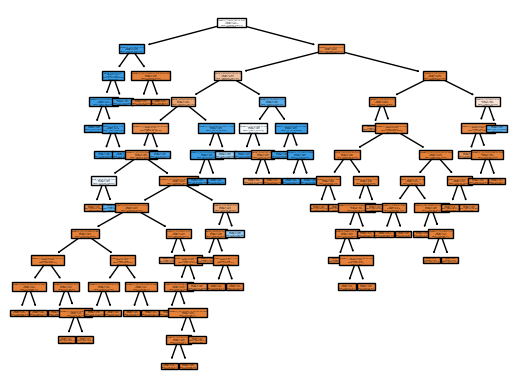

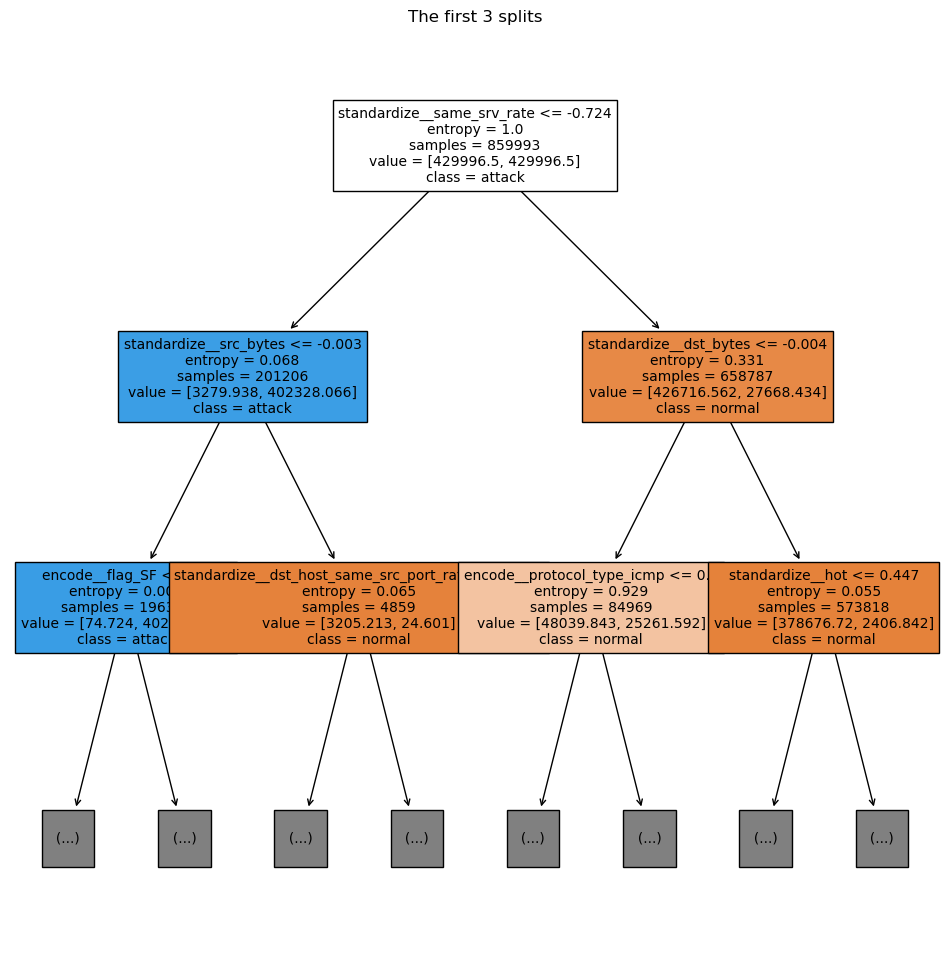

In [47]:
#plot the decision tree

#very zoomed out
plot_tree(model, feature_names=new_feature_names, class_names=["normal", "attack"], filled=True)
plt.show()

#zoomed in to first few splits
#increase size of plot
plt.figure(figsize=(12, 12)) 
plot_tree(model, feature_names=new_feature_names, class_names=["normal", "attack"], filled=True, max_depth=2, fontsize=10)

plt.title("The first 3 splits")
plt.show()

### Model 2: Random Forest - Juan

In [50]:
#TRAINING and SPLITTING DATA FOR RANDOM FOREST
# Split the data into features and target variable

df["binary_label"] = (df["label"] != "normal.").astype(int)

df_tune = df.sample(frac=0.2, random_state=42)  # Use a smaller sample for tuning
X = df_tune.drop(columns=["label", "binary_label"])
y = df_tune["binary_label"]

mask = ~df.index.isin(df_tune.index)
# Full train/test split (used later for the final fit + evaluation)
X_full = df.loc[mask].drop(columns=["label", "binary_label"])
y_full = df.loc[mask, "binary_label"]


# Split the data into training and testing sets
# Stratified split to maintain the distribution of the target variable
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.20, stratify=y_full, random_state=42)


rf = RandomForestClassifier(
    n_jobs       = -1,
    class_weight = "balanced",   # second hedge vs. minority class
    random_state = 42
)

pipeline = ImbPipeline([
    ("pre",   preprocess),   # encoding + scaling
    ("rf",    rf)
])

param_grid = {
    "rf__n_estimators"     : [200, 400],
    "rf__max_depth"        : [None, 20, 40, 60],
    "rf__min_samples_leaf" : [1, 2, 4],
    "rf__max_features"     : ["sqrt", 0.3]  # 0.3 ≈ 30 % of features
}

f2_scorer = make_scorer(fbeta_score, beta=2, zero_division=0)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator      = pipeline,
    param_distributions = param_grid,
    n_iter         = 6,
    scoring        = f2_scorer,
    refit          = True,
    cv             = cv,
    verbose        = 1,
    n_jobs         = -1,
    random_state   = 42
)


search.fit(X, y)
print("Best hyper-parameters:", search.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best hyper-parameters: {'rf__n_estimators': 400, 'rf__min_samples_leaf': 1, 'rf__max_features': 0.3, 'rf__max_depth': 60}


In [51]:
# Building RF with best parameters
best = search.best_params_

rf_final = RandomForestClassifier(
    n_estimators     = best["rf__n_estimators"],
    max_depth        = best["rf__max_depth"],
    min_samples_leaf = best["rf__min_samples_leaf"],
    max_features     = best["rf__max_features"],
    n_jobs           = -1,
    class_weight     = "balanced",
    random_state     = 42,
    verbose          = 1
)

final_pipe = ImbPipeline([
    ("pre",   preprocess),
    ("smote", SMOTE(random_state=42)),
    ("rf",    rf_final)
])

final_pipe.fit(X_train, y_train)

y_pred = final_pipe.predict(X_test)
print("Accuracy :", accuracy_score(y_test, y_pred))
print("F2       :", fbeta_score(y_test, y_pred, beta=2))
print(confusion_matrix(y_test, y_pred))



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  3.2min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.2s


Accuracy : 0.9998488363304437
F2       : 0.9995612822004559
[[130051      4]
 [    22  41922]]


[Parallel(n_jobs=10)]: Done 400 out of 400 | elapsed:    0.4s finished


In [52]:
##RANDOM FOREST EVALUATION and CONFUSION MATRIX
y_pred = final_pipe.predict(X_test)

metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall":    recall_score(y_test, y_pred),
    "F1":        f1_score(y_test, y_pred),
    "F2":        fbeta_score(y_test, y_pred, beta=2),
    "FNR":       1 - recall_score(y_test, y_pred),
}

print(pd.Series(metrics).round(4), "\n")
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred), "\n")
print("Detailed classification report:\n", classification_report(y_test, y_pred), "\n")

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.2s


Accuracy     0.9998
Precision    0.9999
Recall       0.9995
F1           0.9997
F2           0.9996
FNR          0.0005
dtype: float64 

Confusion matrix:
 [[130051      4]
 [    22  41922]] 

Detailed classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    130055
           1       1.00      1.00      1.00     41944

    accuracy                           1.00    171999
   macro avg       1.00      1.00      1.00    171999
weighted avg       1.00      1.00      1.00    171999
 



[Parallel(n_jobs=10)]: Done 400 out of 400 | elapsed:    0.4s finished


In [53]:
#evaluate decision tree's performance
print(pd.Series(metrics).round(4), "\n")
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred), "\n")
print("Detailed classification report:\n", classification_report(y_test, y_pred), "\n")

Accuracy     0.9998
Precision    0.9999
Recall       0.9995
F1           0.9997
F2           0.9996
FNR          0.0005
dtype: float64 

Confusion matrix:
 [[130051      4]
 [    22  41922]] 

Detailed classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    130055
           1       1.00      1.00      1.00     41944

    accuracy                           1.00    171999
   macro avg       1.00      1.00      1.00    171999
weighted avg       1.00      1.00      1.00    171999
 



In [55]:
#Save the model
import joblib, pathlib
pathlib.Path("models").mkdir(exist_ok=True)
joblib.dump(final_pipe, "models/rf_model.pkl")

['models/rf_model.pkl']

### Unsupervised Learners

In [ ]:
#Model 3: K-Means Clustering

In [ ]:
#Model 4: Isolation Forest

### Evaluation

In [ ]:
#Evaluation, Visualization

#mandatory
#accuracy
#recall
#precision

#optional
#F2
#False Negative Rate